## Paper Plots

* [Phase Diagram - Chiral Correlation Length](#first-bullet)
* [Phase Diagram - Chiral Susceptibility](#second-bullet)
* [Phase Diagram - Specific Heat](#third-bullet)
* [Enantiomeric Excess Plot](#fourth-bullet)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.mplot3d import axes3d 
import os
from tqdm.auto import tqdm
from numba import jit
import scipy

plt.style.use('science')

# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
ic = 0
for root, dirs, files in os.walk("../data/pdanneal/"):
    for file in files:
        #print(file)
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)

print(len(simlist))
print(len(datafiles))
print(len(csvfiles))
assert len(simlist) == len(datafiles) == len(csvfiles)


def load_csv(fname,verbose=True):
    if verbose:
        with open(fname) as f:
            print(f.readline().strip('\n'))
    return np.loadtxt(fname,skiprows=1,delimiter=",")

def plot_energy(fpath,csv1,save=False):
    fig,ax1 = plt.subplots()
    ax1.set_title(simlist[0])
    ax1.plot(csv1[:,0],csv1[:,1],label="TotalEnergy")
    ax1.set_xlabel("timesteps")
    ax1.set_ylabel("Total Energy")
    ax1.tick_params(axis ='y', labelcolor="tab:blue")
    ax2  = ax1.twinx()
    ax2.plot(csv1[:,0],csv1[:,2],label="Eexcess",color="tab:orange")
    ax2.set_ylabel("Ent. Excess")
    ax2.tick_params(axis ='y', labelcolor = "tab:orange")
    plt.show()
    if save:
        fname = fpath[:-4]+"_energy.png"
        print(fname)
        fig.savefig(fname)
    
@jit(nopython=True)
def calc_n_corr(nx,ny,nz,nshells):
    g = np.zeros(nshells)
    c = np.zeros(nshells)
    ni,nj,nk = nx.shape
    for i in np.arange(ni):
        for j in np.arange(nj):
            for k in np.arange(nk):
                for di in np.arange(-nshells,nshells+1):
                    for dj in np.arange(-nshells,nshells+1):
                        for dk in np.arange(-nshells,nshells+1):
                            r2 = di*di + dj*dj + dk*dk
                            if r2 < nshells*nshells:
                                rr = np.sqrt(r2)
                                ii = i + di
                                jj = j + dj
                                kk = k + dk
                                if (ii < ni) and (jj < nj) and (kk < nk) and (ii >= 0) and (jj >= 0) and (kk >= 0):
                                    ishell = int(np.floor(rr))
                                    g[ishell] = g[ishell] + (nx[i,j,k]*nx[ii,jj,kk] + ny[i,j,k]*ny[ii,jj,kk] + nz[i,j,k]*nz[ii,jj,kk])**2
                                    c[ishell] += 1
    for ishell in np.arange(nshells):
        g[ishell] = g[ishell]/c[ishell]
    return g,c
                                
@jit(nopython=True)
def calc_s_corr(s,nshells):
    g = np.zeros(nshells)
    c = np.zeros(nshells)
    ni,nj,nk = s.shape
    s_avg2 = np.mean(s)**2
    for i in np.arange(ni):
        for j in np.arange(nj):
            for k in np.arange(nk):
                #print(i,j,k)
                for di in np.arange(-nshells,nshells+1):
                    for dj in np.arange(-nshells,nshells+1):
                        for dk in np.arange(-nshells,nshells+1):
                            r2 = di*di + dj*dj + dk*dk
                            if r2 < nshells*nshells:
                                rr = np.sqrt(r2)
                                ii = i + di
                                jj = j + dj
                                kk = k + dk
                                if (ii < ni) and (jj < nj) and (kk < nk) and (ii >= 0) and (jj >= 0) and (kk >= 0):
                                    ishell = int(np.floor(rr))
                                    #assert ishell > 0
                                    #g[ishell] = g[ishell] + s[i,j,k] * s[ii,jj,kk]# pdanneal_ch_len.npz
                                    g[ishell] = g[ishell] + s[i,j,k] * s[ii,jj,kk] - s_avg2 #pdanneal_ch_len2.npz
                                    c[ishell] += 1
    for ishell in np.arange(nshells):
        g[ishell] = g[ishell]/c[ishell]# - s_avg2
    return g,c

def plot_s_corr(fpath,g):
    nshells = len(g)
    fig,ax = plt.subplots()
    ax.set_title(fpath.split("/")[-2])
    ax.plot(np.arange(nshells),g)
    ax.set_ylabel("Chiral Correlation")
    ax.set_xlabel("Shells")
    plt.show()

def plot_n_corr(fpath,g):
    nshells = len(g)
    fig,ax = plt.subplots()
    ax.set_title(fpath.split("/")[-2])
    ax.plot(np.arange(nshells),g)
    ax.set_ylabel("Nematic Correlation")
    ax.set_xlabel("Shells")
    plt.show()

def func(x, a, l):
    return a * np.exp(-x/l)
    
def fit_corr_exp(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func,np.arange(nshells),g)
    return popt[0],popt[1]

def func2(x, a, l, c):
    return a * np.exp(-x/l) + c
    
def fit_corr_exp2(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func2,np.arange(nshells),g)
    return popt[0],popt[1], popt[2]

def get_temp_K(csvfiles):
    Ks = []
    kbts = []
    for csvfile in csvfiles:
        csv1 = load_csv(csvfile,verbose=False)
        K = float(csvfile.split("/")[3].split("_")[-2][1:])
        kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
        Ks.append(K)
        kbts.append(kbt)#/Tin)
    Ks = sorted(list(set(Ks))) #list of all Ks w/ duplicates removed
    kbts = sorted(list(set(kbts))) # list of all Kbts w/ duplicates removed
    print(Ks)
    print(kbts)
    return kbts,Ks
    
%matplotlib ipympl

default_colormap = 'RdYlBu'#'coolwarm'#'Spectral'#'YlGnBu'
default_fontsize = 24

390
390
390


### Phase diagram plot of chiral correlation length <a name="first-bullet"></a>

In [ ]:
# 3D plot
plt.rcParams['text.usetex'] = True
#data = np.load("large_alignedlong4_ch_l3.npz")
data=np.load("pdanneal_ch_len2.npz")
ch_l = data['ch_l']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
#ax1.view_init(60, -90.01,0) # note -90.01 gets the axes on left side
ax1.view_init(50, -100,0)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
surf1 = ax1.plot_surface(X, Y, ch_l.T, cmap=default_colormap,linewidth=1, antialiased=False)
#surf1 = ax1.plot_wireframe(X, Y, ch_sus.T, cmap='viridis',linewidth=0.5, antialiased=False)
cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.7)
cbar1.set_label(r'$ \xi_c $',fontsize=default_fontsize,labelpad=16,rotation='horizontal')
cbar1.ax.tick_params(labelsize=default_fontsize)

#ax1.set_ylabel(r'$ K/J $',labelpad=24,fontsize=default_fontsize,rotation=90)
ax1.set_xlabel(r'$ T/T_{IN} $',labelpad=8,fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,25)
#ax1.set_zlabel(r'$ \chi_c $',fontsize=16,labelpad=-26)
ax1.zaxis.set_rotate_label(False)
ax1.zaxis.set_label_position("upper")
ax1.zaxis.set_label_coords(1.0,0.5)

[t.set_va('center') for t in ax1.get_yticklabels()]
[t.set_ha('right') for t in ax1.get_yticklabels()]
[t.set_va('center') for t in ax1.get_xticklabels()]
[t.set_ha('center') for t in ax1.get_xticklabels()]
[t.set_va('center') for t in ax1.get_zticklabels()]
[t.set_ha('right') for t in ax1.get_zticklabels()]
ax1.xaxis.set_tick_params(labelsize=default_fontsize)
ax1.yaxis.set_tick_params(labelsize=default_fontsize)
ax1.zaxis.set_tick_params(labelsize=default_fontsize)

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.zaxis.set_major_locator(plt.MaxNLocator(4))

# ax1.text2D(0.175, 0.95,r'$ \chi_c $', 
#           transform=ax1.transAxes, fontsize=16)
ax1.text2D(0.05, 0.92,r'$ \xi_c $', 
          transform=ax1.transAxes, fontsize=default_fontsize,rotation=0)

ax1.text2D(0.0, 0.325,r'$ K/J $', 
          transform=ax1.transAxes, fontsize=default_fontsize,rotation=10)

fig.align_labels()
plt.show()
print(ch_l.T)

In [ ]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_l2.npz")
ch_l = data['ch_l']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.contourf(X, Y, ch_l.T, cmap=default_colormap,levels=default_fontsize) #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \xi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

In [ ]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_l2.npz")
ch_l = data['ch_l']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.imshow(ch_l.T, cmap=default_colormap,origin="lower",extent = (np.min(kbts),np.max(kbts),np.min(Ks),np.max(Ks)),interpolation="antialiased") #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \xi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

### Phase diagram plot of chiral susceptibility <a name="second-bullet"></a>

In [12]:
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/pdanneal/"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)

In [ ]:
# THIS TAKES A LONG TIME TO RUN
kbts,Ks = get_temp_K(csvfiles)
ch_sus = np.zeros((len(Ks),len(kbts)))
print(ch_sus.shape)
N3 = 128**3
for i,Kplot in enumerate(tqdm(Ks)):
    #print(Kplot," ",i+1," / ",len(Ks))
    for j,Tplot in enumerate(kbts):
        for csvfile in csvfiles:
            csv1 = load_csv(csvfile,verbose=False)
            K = float(csvfile.split("/")[3].split("_")[-2][1:])
            kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
            #print("G ",g,gPlot)
            if K == Kplot and kbt == Tplot:# and "phasediaglarge" in csvfile:
                excess = csv1[-500:,2]
                #ch_sus[i,j] = (np.mean(excess**2) - np.mean(excess)**2)/(kbt*N3**2)
                ch_sus[i,j] = N3*(np.mean(excess**2) - np.mean(excess)**2)/(kbt)

#np.savez_compressed("large_alignedlong4_ch_sus3.npz",ch_sus=ch_sus)
np.savez_compressed("pdanneal_ch_sus.npz",ch_sus=ch_sus)

In [ ]:

plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

data = np.load("pdanneal_ch_sus.npz")
ch_sus = data['ch_sus']

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
#ax1.set_ylabel(r'$ K/J $',labelpad=24,fontsize=default_fontsize)
ax1.set_xlabel(r'$ T/T_{IN} $',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $',fontsize=16,labelpad=-26)
ax1.zaxis.set_rotate_label(False)
print(ax1.zaxis.get_label_position())
ax1.zaxis.set_label_position("upper")
ax1.zaxis.set_label_coords(1.0,0.5)

ax1.view_init(60, -90.01,0) # note -90.01 gets the axes on left side
ax1.view_init(50, -100,0)
ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

surf1 = ax1.plot_surface(X, Y, ch_sus, cmap=default_colormap,linewidth=1, antialiased=False)
#surf1 = ax1.plot_wireframe(X, Y, ch_sus.T, cmap='viridis',linewidth=0.5, antialiased=False)
cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.7)
cbar1.set_label(r'$ \chi_c $',fontsize=default_fontsize, rotation=90)
cbar1.ax.tick_params(labelsize=default_fontsize)

[t.set_va('center') for t in ax1.get_yticklabels()]
[t.set_ha('right') for t in ax1.get_yticklabels()]
[t.set_va('center') for t in ax1.get_xticklabels()]
[t.set_ha('right') for t in ax1.get_xticklabels()]
[t.set_va('center') for t in ax1.get_zticklabels()]
[t.set_ha('right') for t in ax1.get_zticklabels()]
ax1.xaxis.set_tick_params(labelsize=default_fontsize)
ax1.yaxis.set_tick_params(labelsize=default_fontsize)
ax1.zaxis.set_tick_params(labelsize=default_fontsize)

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.zaxis.set_major_locator(plt.MaxNLocator(4))

# ax1.text2D(0.175, 0.95,r'$ \chi_c $', 
#           transform=ax1.transAxes, fontsize=16)
ax1.text2D(0.0, 0.9,r'$ \chi_c $', 
          transform=ax1.transAxes, fontsize=default_fontsize,rotation=0)

ax1.text2D(0.0, 0.325,r'$ K/J $', 
          transform=ax1.transAxes, fontsize=default_fontsize,rotation=10)
fig.align_labels()
plt.show()

In [ ]:
plt.rcParams['text.usetex'] = True
data = np.load("alignedlong4_ch_sus.npz")
ch_sus = data['ch_sus']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.contourf(X, Y, ch_sus, cmap=default_colormap,levels=default_fontsize) #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \chi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


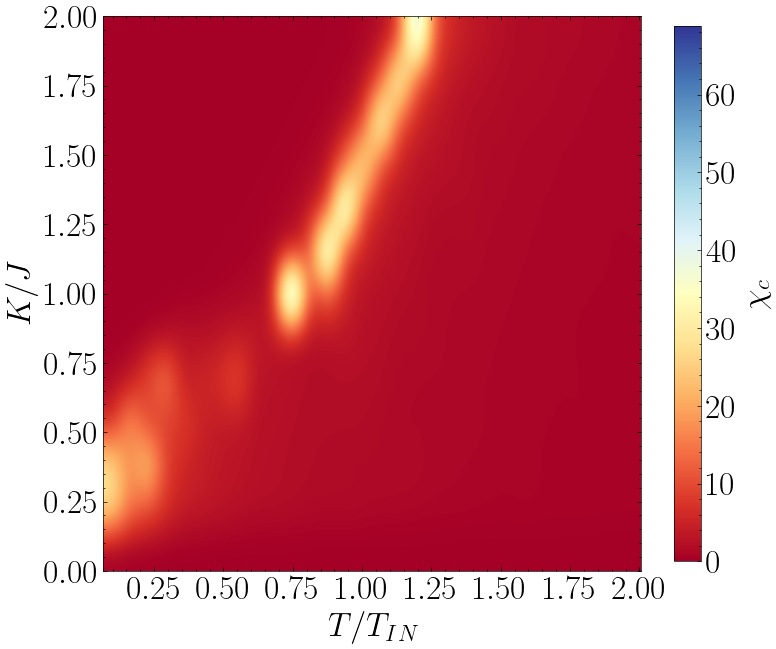

In [15]:
plt.rcParams['text.usetex'] = True
data = np.load("pdanneal_ch_sus.npz")
ch_sus = data['ch_sus']
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.imshow(ch_sus, cmap=default_colormap,origin="lower",extent = (np.min(kbts),np.max(kbts),np.min(Ks),np.max(Ks)),interpolation="bicubic") #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ \chi_c $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

### Phase diagram plot of specific heat <a name="third-bullet"></a>

In [7]:
# 3d chiral susceptibility
# get all Ks and kbts for a range
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/pdanneal/"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)


Ks = []
kbts = []
for csvfile in csvfiles:
    csv1 = load_csv(csvfile,verbose=False)
    K = float(csvfile.split("/")[3].split("_")[-2][1:])
    kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
    Ks.append(K)
    kbts.append(kbt)
    
Ks = sorted(list(set(Ks))) #list of all Ks w/ duplicates removed
# Ks1 = Ks[:10] # 0.001 -> 0.01
# Ks2 = Ks[9:19] # 0.01 -> 0.1
# Ks3 = Ks[18:] # 0.1 -> 1.0
kbts = sorted(list(set(kbts))) # list of all Kbts w/ duplicates removed
print(Ks)
print(kbts)
#assert len(Ks1) == len(Ks2) == len(Ks3)

C_v = np.empty((len(kbts),len(Ks)))
print(C_v.shape)
for csvfile in tqdm(csvfiles):
    csv1 = load_csv(csvfile,verbose=False)
    K = float(csvfile.split("/")[3].split("_")[-2][1:])
    kbt = float(csvfile.split("/")[3].split("_")[-1][3:])
    if K in Ks :#and "alignedlong4" in csvfile:
        K_index = Ks.index(K)
        kbt_index = kbts.index(kbt)
        #specific heat
        #print(csv1.shape)
        E = csv1[-500:,1]
        tmp = (np.mean(E**2) - np.mean(E)**2)/kbt
        # if tmp > 0.00001:
        #     tmp = 0.00001
        #C_v[kbt_index,K_index] = np.log(tmp)
        C_v[kbt_index,K_index] = np.log10(tmp)
#print(C_v)

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]
(30, 13)


  0%|          | 0/390 [00:00<?, ?it/s]

In [ ]:
# 3D plot
interpolation_factor = 2

plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)
dx = np.abs(kbts[1]-kbts[0])/interpolation_factor
dy = np.abs(Ks[1]-Ks[2])/interpolation_factor
print(dx,dy)
kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(10,10),subplot_kw={"projection": "3d"})
#ax1.set_ylabel(r'$ K/J $',labelpad=24,fontsize=default_fontsize)
ax1.set_xlabel(r'$ T/T_{IN} $',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ log \left(c_p \right) $',fontsize=default_fontsize, rotation=90)
ax1.zaxis.set_rotate_label(False)
#print(ax1.zaxis.get_label_position())
#ax1.zaxis.set_label_position("upper")
#ax1.zaxis.set_label_coords(1.0,0.5)

ax1.view_init(60, -90.01,0) # note -90.01 gets the axes on left side
#ax1.view_init(20, -90.01,0) # note -90.01 gets the axes on left side
ax1.view_init(50, -100,0)

ax1.xaxis.pane.set_edgecolor('black')
ax1.yaxis.pane.set_edgecolor('black')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
#SMOOTHING

interp_Ks = [k*Jinverse for k in np.arange(0.0,3.1,dy)]
interp_kbts = [t/Tin for t in np.arange(0.05,1.51,dx)]
Xi,Yi = np.meshgrid(interp_kbts,interp_Ks)

#RegularGridInterpolator
interp = scipy.interpolate.RegularGridInterpolator([kbts,Ks],C_v,fill_value=None,bounds_error=False)
Zi = interp((Xi,Yi),method='linear')
surf1 = ax1.plot_surface(Xi,Yi,Zi,cmap=default_colormap,linewidth=1,antialiased=False)

# RectBivariateSpline doesn't do high-gradient regions well
#interp = scipy.interpolate.RectBivariateSpline(Ks,kbts, C_v.T,s=0)
#Zi = interp (interp_Ks,interp_kbts)
#surf1 = ax1.plot_surface(Xi, Yi, Zi, cmap=default_colormap,linewidth=1, antialiased=False)

#surf1 = ax1.plot_surface(X, Y, C_v.T, cmap=default_colormap,linewidth=1, antialiased=False)
cbar1 = plt.colorbar(surf1, ax=ax1,shrink=0.7)
cbar1.set_label(r'$ log \left(c_p \right) $',fontsize=default_fontsize, rotation=90)
cbar1.ax.tick_params(labelsize=default_fontsize)

[t.set_va('center') for t in ax1.get_yticklabels()]
[t.set_ha('right') for t in ax1.get_yticklabels()]
[t.set_va('center') for t in ax1.get_xticklabels()]
[t.set_ha('right') for t in ax1.get_xticklabels()]
[t.set_va('center') for t in ax1.get_zticklabels()]
[t.set_ha('right') for t in ax1.get_zticklabels()]
ax1.xaxis.set_tick_params(labelsize=default_fontsize)
ax1.yaxis.set_tick_params(labelsize=default_fontsize)
ax1.zaxis.set_tick_params(labelsize=default_fontsize)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.zaxis.set_major_locator(plt.MaxNLocator(4))

# ax1.text2D(0.175, 0.95,r'$ \chi_c $', 
#           transform=ax1.transAxes, fontsize=16)
ax1.text2D(0.01, 0.9,r'$ log \left(c_p \right) $', 
          transform=ax1.transAxes, fontsize=default_fontsize, rotation=0)
ax1.text2D(0.0, 0.325,r'$ K/J $', 
          transform=ax1.transAxes, fontsize=default_fontsize,rotation=10)
fig.align_labels()
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


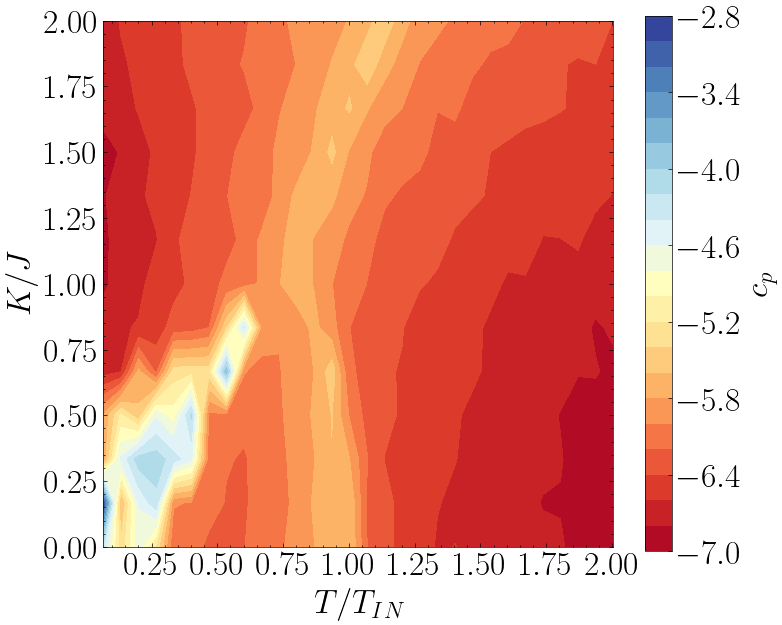

In [8]:
plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.contourf(X, Y, C_v.T, cmap=default_colormap,levels=default_fontsize) #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ c_p $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]


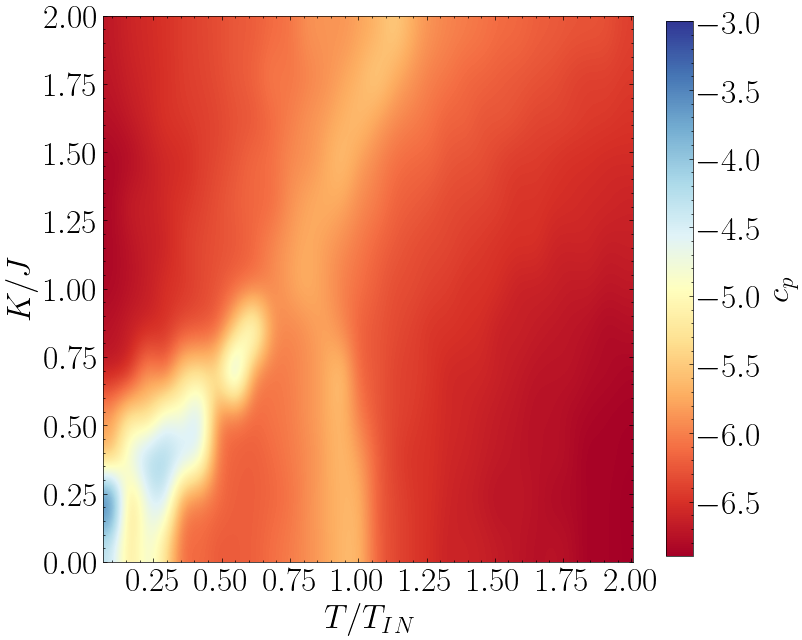

In [16]:
plt.rcParams['text.usetex'] = True
Tin = 1.1224*(2.0/3.0)
Jinverse = (2.0/3.0)
kbts,Ks = get_temp_K(csvfiles)

kbts = [t/Tin for t in kbts]
Ks = [k*Jinverse for k in Ks] # adjusting these parameters for their corrected values
X,Y = np.meshgrid(kbts,Ks)
fig,ax1 = plt.subplots(figsize=(8,8))
ax1.set_ylabel(r'\textbf{$ K/J $}',fontsize=default_fontsize)
ax1.set_xlabel(r'\textbf{$ T/T_{IN} $}',fontsize=default_fontsize)
ax1.set_xlim(np.min(kbts),np.max(kbts))
ax1.set_ylim(np.min(Ks),np.max(Ks))
#ax1.set_zlim(0,64)
#ax1.set_zlabel(r'$ \chi_c $')
cont1 = ax1.imshow(C_v.T, cmap=default_colormap,origin="lower",extent = (np.min(kbts),np.max(kbts),np.min(Ks),np.max(Ks)),interpolation="bicubic") #BuPu
#cont1 = ax1.contour(X, Y, ch_sus, cmap='viridis',levels=16)
cbar1 = plt.colorbar(cont1, ax=ax1,spacing="uniform",shrink=0.715)
cbar1.set_label(r'\textbf{$ c_p $}', rotation=90,fontsize=default_fontsize)
cbar1.ax.tick_params(labelsize=default_fontsize)
plt.xticks(fontsize=default_fontsize)
plt.yticks(fontsize=default_fontsize)
ax1.set_aspect(1)
fig.tight_layout()
plt.show()

### Enantiomeric Excess Plot <a name="fourth-bullet"></a>

In [ ]:
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/ganneal"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)
plt.rcParams['text.usetex'] = True

Jinverse = (2.0/3.0)
def g_plot(Tplot):
    Tplot = np.around(Tplot,2)
    init_type="ganneal"
    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125)
    for Kplot in np.arange(0.0,1.1,0.25):
    #for Kplot in tqdm(np.arange(0.0,1.1,0.25)):
    #for Kplot in tqdm(np.arange(0.0,0.1,0.25)):
        X,Y = [],[]
        for gPlot in np.arange(0.0,0.251,0.0025):
            for csvfile in csvfiles:
                csv1 = load_csv(csvfile,verbose=False)
                K = float(csvfile.split("/")[3].split("_")[-3][1:])
                #KoJ = K*Jinverse
                kbt = float(csvfile.split("/")[3].split("_")[-2][3:])
                g = float(csvfile.split("/")[3].split("_")[-1][1:])
                #print("G ",g,gPlot,K,kbt,csvfile)
                if K == Kplot and kbt == Tplot and g == np.around(gPlot,2) and init_type in csvfile:
                    #print(K,g,kbt,g/kbt)
                    X.append(g/kbt)
                    Y.append(np.abs(np.mean(csv1[7500:,2])))
        zipped = list(zip(X,Y))
        zipped.sort()
        X,Y = zip(*zipped)
        np.savetxt("ent_ex_annealed_K"+str(np.around(Kplot*Jinverse,3))+"_kbt"+str(Tplot)+".csv",np.vstack((X,Y)).T,delimiter=',',header='K/J='+str(np.around(Kplot*Jinverse,3))+' kBT='+str(Tplot)+'\ng/kbt,<Ent.Ex.>')
        #ax.scatter(X,Y,marker='x',linewidth=2,zorder=2)
        #ax.set_title("kbt="+str(Tplot))
        ax.plot(X,Y,marker='x',markeredgewidth=2,linewidth=2,linestyle='dashed',label=r"\textbf{$K/J$}: "+str(np.around(Kplot*Jinverse,3)),zorder=2)
        #ax.plot(X,Y,marker='x',linewidth=2,linestyle='dashed',label=str(np.around(Kplot*Jinverse,3)),zorder=2)
        ax.set_ylabel(r'\textbf{ $\eta$}',fontsize=default_fontsize)
        ax.set_xlabel(r'\textbf{$g/k_B T$}',fontsize=default_fontsize)

    ax.plot(X,np.tanh(X),linewidth=2,linestyle='solid',label=r"$tanh(\frac{g}{k_B T})$",color='k',zorder=1)
    plt.xticks(fontsize=default_fontsize)
    plt.yticks(fontsize=default_fontsize)
    plt.legend(fontsize=default_fontsize-6,loc="upper left")
    fig.tight_layout()
    plt.show()

# for t in np.arange(0.5,0.04,-0.05):
#     print(t)
#     g_plot(t)
from joblib import Parallel, delayed
Parallel(n_jobs=10,verbose=10)(delayed(g_plot)(t) for t in np.arange(0.5,0.04,-0.05))

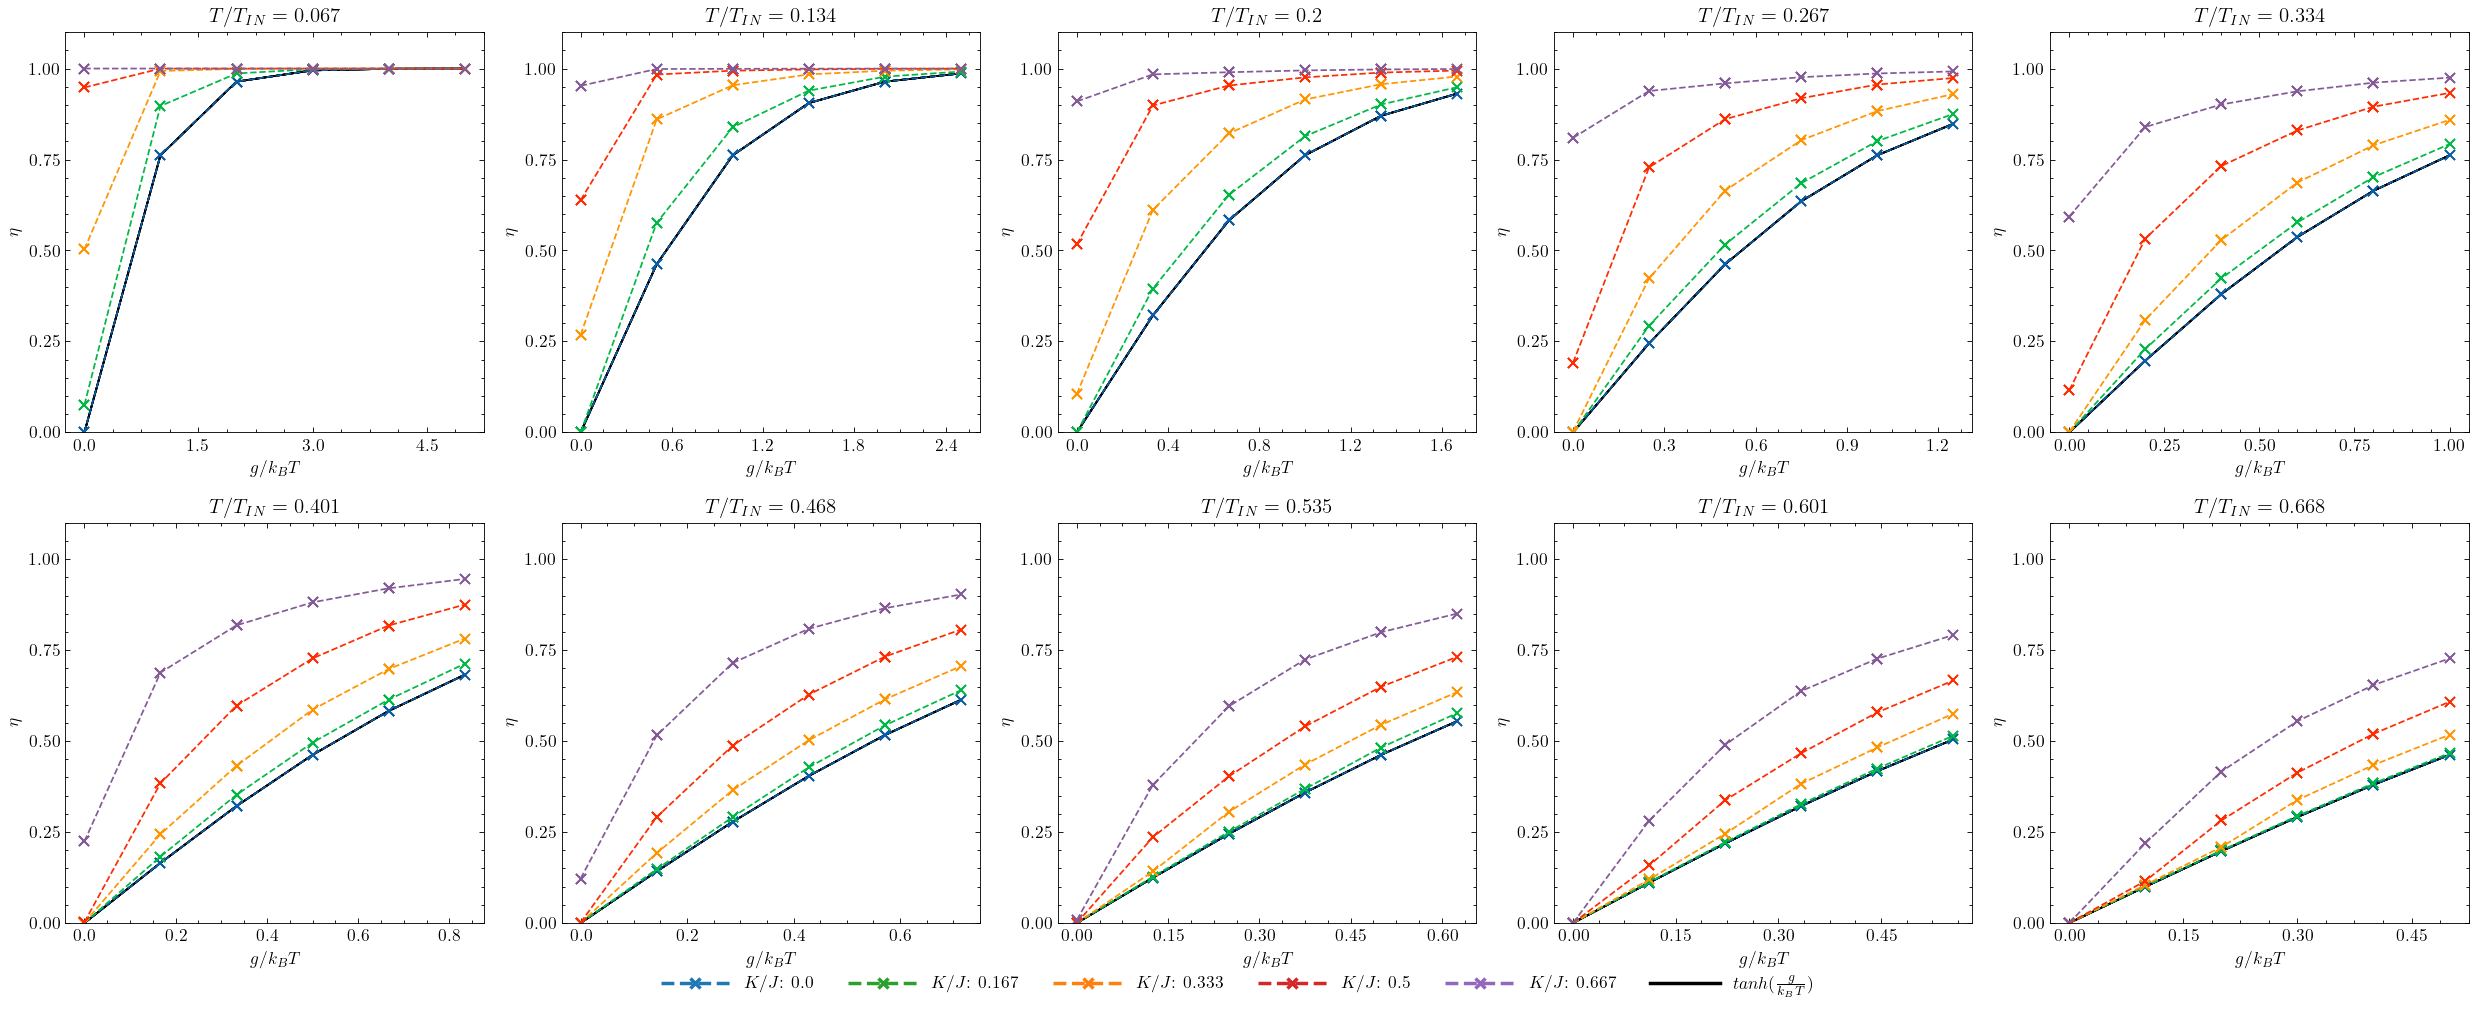

In [20]:
from matplotlib.lines import Line2D
csvfiles = []
for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".csv") and "ent_ex_annealed" in file and "checkpoint" not in file:
            csvfiles.append(os.path.join(root,file))
csvfiles = sorted(csvfiles)
Tin = 1.1224*(2.0/3.0)
plt.close('all')
fig,axs = plt.subplots(2,5,figsize=(20,8),dpi=125)
plot_kbts = np.array([[0.05,0.1,0.15,0.2,0.25],[0.3,0.35,0.4,0.45,0.5]])
for file in csvfiles:
    with open(file,"r") as f:
        header = f.readline()
    KoJ = float(header.split(" ")[1].split("=")[-1].strip())
    kbt = float(header.split(" ")[2].split("=")[-1].strip())
    #print(kbt in plot_kbts, np.argwhere(plot_kbts==kbt)[0])
    #break
    if kbt in plot_kbts:
        idx = list(np.argwhere(plot_kbts==kbt)[0])
        #print(list(idx))
        data = np.loadtxt(file,skiprows=1,delimiter=',')
        X = data[:,0]
        Y = data[:,1]
        axs[idx[0],idx[1]].plot(X,Y,marker='x',markeredgewidth=1,linewidth=1,linestyle='dashed',label=r"\textbf{$K/J$}: "+str(np.around(KoJ,3)),zorder=2)
        #ax.plot(X,Y,marker='x',linewidth=2,linestyle='dashed',label=str(np.around(Kplot*Jinverse,3)),zorder=2)
        axs[idx[0],idx[1]].set_ylim(0.0,1.1)
        #axs[idx[0],idx[1]].set_xlim(0.0,5.5)
        axs[idx[0],idx[1]].set_ylabel(r'\textbf{ $\eta$}')#,fontsize=default_fontsize)
        axs[idx[0],idx[1]].set_xlabel(r'\textbf{$g/k_B T$}')#,fontsize=default_fontsize)
        axs[idx[0],idx[1]].set_title(r'\textbf{$T/T_{IN} =' + str(np.round(kbt/Tin,3)) + '$}')#,fontsize=default_fontsize)
        axs[idx[0],idx[1]].plot(X,np.tanh(X),linewidth=1,linestyle='solid',label=r"$tanh(\frac{g}{k_B T})$",color='k',zorder=1)
        axs[idx[0],idx[1]].xaxis.set_major_locator(plt.MaxNLocator(5))
        axs[idx[0],idx[1]].yaxis.set_major_locator(plt.MaxNLocator(5))
        # axs[idx[0],idx[1]].set_adjustable('box')
        # axs[idx[0],idx[1]].set_aspect('equal')
plt.xticks()#fontsize=default_fontsize)
plt.yticks()#fontsize=default_fontsize)
# custom legend
custom_lines = [Line2D([0], [0], marker='x',markeredgewidth=2,linestyle='dashed', color='tab:blue', lw=2),
                Line2D([0], [0], marker='x',markeredgewidth=2,linestyle='dashed',color='tab:green', lw=2),
                Line2D([0], [0], marker='x',markeredgewidth=2,linestyle='dashed',color='tab:orange', lw=2),
                Line2D([0], [0], marker='x',markeredgewidth=2,linestyle='dashed',color='tab:red', lw=2),
                Line2D([0], [0], marker='x',markeredgewidth=2,linestyle='dashed',color='tab:purple', lw=2),
                Line2D([0], [0], linestyle='solid',color='k', lw=2)]
fig.legend(custom_lines,
           [r"\textbf{$K/J$}: "+str(0.0),
            r"\textbf{$K/J$}: "+str(0.167),
            r"\textbf{$K/J$}: "+str(0.333),
            r"\textbf{$K/J$}: "+str(0.5),
            r"\textbf{$K/J$}: "+str(0.667),
            r"$tanh(\frac{g}{k_B T})$"],
           ncols=6,loc='lower center',handlelength=4.0,bbox_to_anchor=(0.5,-0.025))
fig.tight_layout()
#plt.savefig("enx_ex.png",bbox_inches='tight')


550


  0%|          | 0/10 [00:00<?, ?it/s]

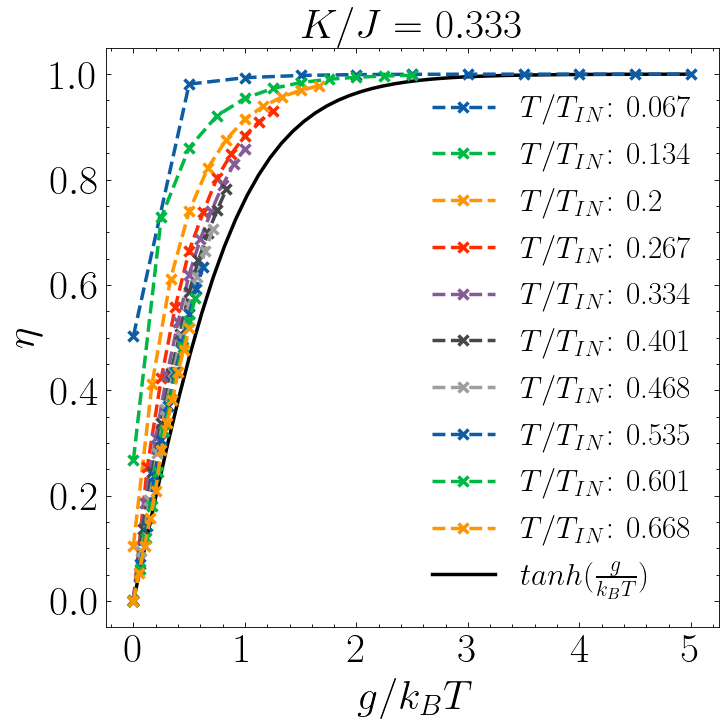

In [24]:
# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/ganneal"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
print(len(csvfiles))
assert len(simlist) == len(datafiles) == len(csvfiles)
plt.rcParams['text.usetex'] = True

Jinverse = (2.0/3.0)
Tin = 1.1224*(2.0/3.0)
def g_plot2(Kplot):
    Kplot = np.around(Kplot,2)
    init_type="ganneal"
    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125)
    for Tplot in tqdm(np.arange(0.05,0.51,0.05)):
        X,Y = [],[]
        for gPlot in np.arange(0.0,0.251,0.025):
            for csvfile in csvfiles:
                K = float(csvfile.split("/")[3].split("_")[-3][1:])
                kbt = float(csvfile.split("/")[3].split("_")[-2][3:])
                g = float(csvfile.split("/")[3].split("_")[-1][1:])
                #print("G ",g,gPlot,K,kbt,csvfile)
                if init_type in csvfile and np.isclose(K,Kplot) and np.isclose(kbt,Tplot) and np.isclose(g,gPlot):
                #if K == Kplot and kbt == Tplot and g == gPlot and init_type in csvfile:
                    #print(K,kbt,g,gPlot,K==Kplot,kbt==Tplot,g==gPlot)
                    #print(K,kbt,g,gPlot,np.isclose(K,Kplot),np.isclose(kbt,Tplot),np.isclose(g,gPlot))
                    csv1 = load_csv(csvfile,verbose=False)
                    X.append(g/kbt)
                    Y.append(np.abs(np.mean(csv1[7500:,2])))
        zipped = list(zip(X,Y))
        zipped.sort()
        X,Y = zip(*zipped)
        #np.savetxt("ent_ex_annealed_K"+str(np.around(Kplot*Jinverse,3))+"_kbt"+str(Tplot)+".csv",np.vstack((X,Y)).T,delimiter=',',header='K/J='+str(np.around(Kplot*Jinverse,3))+' kBT='+str(Tplot)+'\ng/kbt,<Ent.Ex.>')
        ax.plot(X,Y,marker='x',markeredgewidth=2,linewidth=2,linestyle='dashed',label=r"\textbf{$T/T_{IN}$}: "+str(np.around(Tplot/Tin,3)),zorder=2)
        ax.set_ylabel(r'\textbf{ $\eta$}',fontsize=default_fontsize)
        ax.set_xlabel(r'\textbf{$g/k_B T$}',fontsize=default_fontsize)
    ax.set_title(r'\textbf{$K/J =' + str(np.round(Kplot*Jinverse,3)) + '$}',fontsize=default_fontsize)
    ax.plot(np.linspace(0,5),np.tanh(np.linspace(0,5)),linewidth=2,linestyle='solid',label=r"$tanh(\frac{g}{k_B T})$",color='k',zorder=1)
    plt.xticks(fontsize=default_fontsize)
    plt.yticks(fontsize=default_fontsize)
    plt.legend(fontsize=default_fontsize-6,loc="lower right")
    fig.tight_layout()
    plt.show()

g_plot2(0.5)

550


  0%|          | 0/10 [00:00<?, ?it/s]

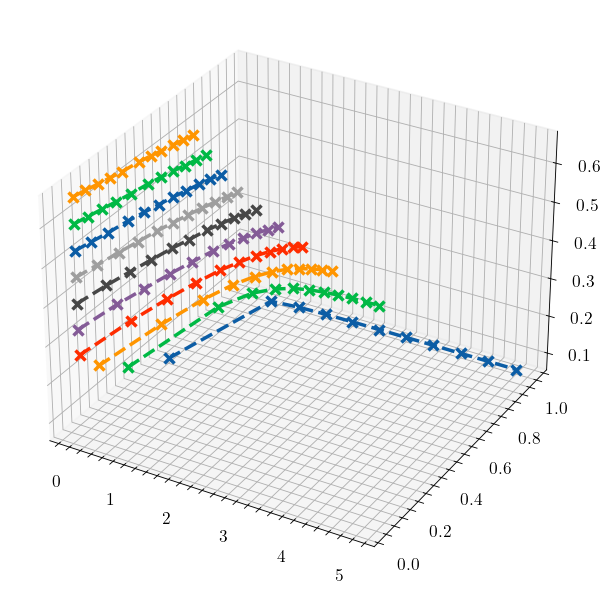

In [17]:
#3D plot of enantomeric excess as a function of time
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/ganneal"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
print(len(csvfiles))
assert len(simlist) == len(datafiles) == len(csvfiles)
plt.rcParams['text.usetex'] = True

Jinverse = (2.0/3.0)
Tin = 1.1224*(2.0/3.0)
def g_plot_surf(Kplot):
    Kplot = np.around(Kplot,2)
    init_type="ganneal"
    surf_data = np.zeros((10,11))
    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125,subplot_kw={"projection": "3d"})
    #fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125)
    for iy,Tplot in enumerate(tqdm(np.arange(0.05,0.51,0.05))):
        X,Y = [],[]
        for ix,gPlot in enumerate(np.arange(0.0,0.251,0.025)):
            for csvfile in csvfiles:
                K = float(csvfile.split("/")[3].split("_")[-3][1:])
                kbt = float(csvfile.split("/")[3].split("_")[-2][3:])
                g = float(csvfile.split("/")[3].split("_")[-1][1:])
                #print("G ",g,gPlot,K,kbt,csvfile)
                if init_type in csvfile and np.isclose(K,Kplot) and np.isclose(kbt,Tplot) and np.isclose(g,gPlot):
                #if K == Kplot and kbt == Tplot and g == gPlot and init_type in csvfile:
                    #print(K,kbt,g,gPlot,K==Kplot,kbt==Tplot,g==gPlot)
                    #print(K,kbt,g,gPlot,np.isclose(K,Kplot),np.isclose(kbt,Tplot),np.isclose(g,gPlot))
                    csv1 = load_csv(csvfile,verbose=False)
                    X.append(g/kbt)
                    Y.append(np.abs(np.mean(csv1[7500:,2])))
        zipped = list(zip(X,Y))
        zipped.sort()
        X,Y = zip(*zipped)
        surf_data[iy,:] = Y
        ax.plot(X,Y,Tplot/Tin,marker='x',markeredgewidth=2,linewidth=2,linestyle='dashed',label=r"\textbf{$T/T_{IN}$}: "+str(np.around(Tplot/Tin,3)),zorder=2)
    plt.show()

def g_plot_surf2(Kplot):
    Kplot = np.around(Kplot,2)
    init_type="ganneal"
    surf_data = np.zeros((10,11))
    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125,subplot_kw={"projection": "3d"})
    #fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125)
    Xs = []
    Ys = []
    Zs = []
    for iy,Tplot in enumerate(tqdm(np.arange(0.05,0.51,0.05))):
        for ix,gPlot in enumerate(np.arange(0.0,0.251,0.025)):
            for csvfile in csvfiles:
                K = float(csvfile.split("/")[3].split("_")[-3][1:])
                kbt = float(csvfile.split("/")[3].split("_")[-2][3:])
                g = float(csvfile.split("/")[3].split("_")[-1][1:])
                #print("G ",g,gPlot,K,kbt,csvfile)
                if init_type in csvfile and np.isclose(K,Kplot) and np.isclose(kbt,Tplot) and np.isclose(g,gPlot):
                #if K == Kplot and kbt == Tplot and g == gPlot and init_type in csvfile:
                    #print(K,kbt,g,gPlot,K==Kplot,kbt==Tplot,g==gPlot)
                    #print(K,kbt,g,gPlot,np.isclose(K,Kplot),np.isclose(kbt,Tplot),np.isclose(g,gPlot))
                    csv1 = load_csv(csvfile,verbose=False)
                    Xs.append(g/kbt)
                    Ys.append(Tplot/Tin)
                    Zs.append(np.abs(np.mean(csv1[7500:,2])))
    zipped = list(zip(Xs,Ys,Zs))
    zipped.sort()
    Xs,Ys,Zs = zip(*zipped)
    #ax.tripcolor(Xs,Ys,Zs)
    ax.scatter(Xs,Ys,Zs)
    plt.show()
    
g_plot_surf(0.5)

In [ ]:
# chiral susceptibility
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/ganneal"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
assert len(simlist) == len(datafiles) == len(csvfiles)
plt.rcParams['text.usetex'] = True

Jinverse = (2.0/3.0)
def g_plot(Tplot):
    Tplot = np.around(Tplot,2)
    init_type="gfieldlarge"
    fig,ax = plt.subplots(1,1,figsize=(6,6),dpi=125)
    for Kplot in tqdm(np.arange(0.0,1.1,0.25)):
    #for Kplot in tqdm(np.arange(0.0,0.1,0.25)):
        X,Y = [],[]
        gPlot = 0.0
        for csvfile in csvfiles:
            csv1 = load_csv(csvfile,verbose=False)
            K = float(csvfile.split("/")[3].split("_")[-3][1:])
            #KoJ = K*Jinverse
            kbt = float(csvfile.split("/")[3].split("_")[-2][3:])
            g = float(csvfile.split("/")[3].split("_")[-1][1:])
            #print("G ",g,gPlot,K,kbt,csvfile)
            if K == Kplot and kbt == Tplot and g == np.around(gPlot,2) and init_type in csvfile:
                #print(K,g,kbt,g/kbt)
                X.append(K*Jinverse)
                excess = csv1[7500:,2]
                ch_sus = (np.mean(excess**2) - np.mean(excess)**2)
                Y.append(ch_sus)
        zipped = list(zip(X,Y))
        zipped.sort()
        X,Y = zip(*zipped)
        #np.savetxt("ent_ex_K"+str(np.around(Kplot*Jinverse,3))+"_kbt"+str(Tplot)+".csv",np.vstack((X,Y)).T,delimiter=',',header='K/J='+str(np.around(Kplot*Jinverse,3))+' kBT='+str(Tplot)+'\ng/kbt,<Ent.Ex.>')
        #ax.scatter(X,Y,marker='x',linewidth=2,zorder=2)
        #ax.set_title("kbt="+str(Tplot))
        ax.plot(X,Y,marker='x',markeredgewidth=2,linewidth=2,linestyle='dashed',label=r"\textbf{$K/J$}: "+str(np.around(Kplot*Jinverse,3)),zorder=2)
        #ax.plot(X,Y,marker='x',linewidth=2,linestyle='dashed',label=str(np.around(Kplot*Jinverse,3)),zorder=2)
        ax.set_ylabel(r'\textbf{ $\chi_c$}',fontsize=default_fontsize)
        ax.set_xlabel(r'\textbf{$K/J$}',fontsize=default_fontsize)

    #ax.plot(X,np.tanh(X),linewidth=2,linestyle='solid',label=r"$tanh(\frac{g}{k_B T})$",color='k',zorder=1)
    plt.xticks(fontsize=default_fontsize)
    plt.yticks(fontsize=default_fontsize)
    plt.legend(fontsize=default_fontsize-6,loc="best")
    fig.tight_layout()
    plt.show()

g_plot(0.5)

### Hero Plots

In [2]:
datafile = "../data/hero48020/hero48020_data.npz"
data = np.load(datafile)
s = data['s']

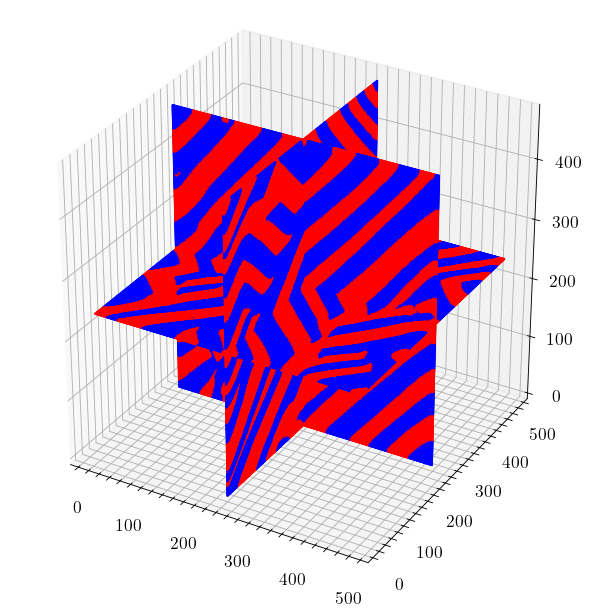

In [5]:
def plot_quadrants(ax, array, fixed_coord, cmap):
    """For a given 3d *array* plot a plane with *fixed_coord*, using four quadrants."""
    nx, ny, nz = array.shape
    index = {
        'x': (nx // 2, slice(None), slice(None)),
        'y': (slice(None), ny // 2, slice(None)),
        'z': (slice(None), slice(None), nz // 2),
    }[fixed_coord]
    plane_data = array[index]

    n0, n1 = plane_data.shape
    quadrants = [
        plane_data[:n0 // 2, :n1 // 2],
        plane_data[:n0 // 2, n1 // 2:],
        plane_data[n0 // 2:, :n1 // 2],
        plane_data[n0 // 2:, n1 // 2:]
    ]

    min_val = array.min()
    max_val = array.max()

    cmap = plt.get_cmap(cmap)

    for i, quadrant in enumerate(quadrants):
        facecolors = cmap((quadrant - min_val) / (max_val - min_val))
        if fixed_coord == 'x':
            Y, Z = np.mgrid[0:ny // 2, 0:nz // 2]
            X = nx // 2 * np.ones_like(Y)
            Y_offset = (i // 2) * ny // 2
            Z_offset = (i % 2) * nz // 2
            ax.plot_surface(X, Y + Y_offset, Z + Z_offset, rstride=1, cstride=1,
                            facecolors=facecolors, shade=False)
        elif fixed_coord == 'y':
            X, Z = np.mgrid[0:nx // 2, 0:nz // 2]
            Y = ny // 2 * np.ones_like(X)
            X_offset = (i // 2) * nx // 2
            Z_offset = (i % 2) * nz // 2
            ax.plot_surface(X + X_offset, Y, Z + Z_offset, rstride=1, cstride=1,
                            facecolors=facecolors, shade=False)
        elif fixed_coord == 'z':
            X, Y = np.mgrid[0:nx // 2, 0:ny // 2]
            Z = nz // 2 * np.ones_like(X)
            X_offset = (i // 2) * nx // 2
            Y_offset = (i % 2) * ny // 2
            ax.plot_surface(X + X_offset, Y + Y_offset, Z, rstride=1, cstride=1,
                            facecolors=facecolors, shade=False)


def figure_3D_array_slices(array, i,cmap=None):
    """Plot a 3d array using three intersecting centered planes."""
    fig = plt.figure(figsize=(6,6),dpi=125)
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect(array.shape)
    plot_quadrants(ax, array, 'x', cmap=cmap)
    plot_quadrants(ax, array, 'y', cmap=cmap)
    plot_quadrants(ax, array, 'z', cmap=cmap)
    ax.view_init(30,-60+10*i)
    return fig, ax

i = 0
figure_3D_array_slices(data['s'], i,cmap='bwr')
plt.show()

In [ ]:
#3d energy plot
import plotly.graph_objects as go
from plotly.offline import iplot,init_notebook_mode
init_notebook_mode(connected=True)

s = data['s']
shape = s.shape

x,y,z = np.indices(shape)
fig = go.Figure(data = go.Volume(
                x = x.flatten(),
                y = y.flatten(),
                z = z.flatten(),
                value = s.flatten(),
                colorscale='Viridis',
                opacity=0.1,
                surface_count=17,
                isomin = 0,
                isomax = 1))
fig.update_layout(
    autosize=True,
    width=800,
    height=800,
    scene = dict(
        xaxis_title = "X Axis",
        yaxis_title = "Y Axis",
        zaxis_title = "Z Axis"))
fig.show()